The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# Bahdanau 注意力
:label:`sec_seq2seq_attention`

我们在 :numref:`sec_seq2seq` 中研究了机器翻译问题，在那里我们设计了一个基于两个循环神经网络的编码器-解码器架构，用于顺序到序列的学习。具体来说，循环神经网络编码器将可变长度序列转换为固定形状的上下文变量，然后循环神经网络解码器根据生成的标记和上下文变量按标记生成输出（目标）序列标记。但是，即使并非所有输入（源）标记都对解码某个标记都有用，但在每个解码步骤中仍使用编码整个输入序列的**相同**上下文变量。

在为给定文本序列生成手写的一个单独但相关的挑战中，格雷夫斯设计了一种可区分的注意力模型，将文本字符与更长的笔迹对齐，其中对齐方式仅向一个方向移动 :cite:`Graves.2013`。受学习对齐想法的启发，Bahdanau 等人提出了一个没有严格的单向对齐限制 :cite:`Bahdanau.Cho.Bengio.2014` 的可区分注意力模型。在预测标记时，如果不是所有输入标记都相关，模型将仅对齐（或参与）输入序列中与当前预测相关的部分。这是通过将上下文变量视为注意力集中的输出来实现的。

## 模型

在下面描述 Bahdanau 注意力对循环神经网络编码器的关注时，我们将遵循 :numref:`sec_seq2seq` 中的相同符号。新的基于注意的模型与 :numref:`sec_seq2seq` 中的模型相同，只不过 :eqref:`eq_seq2seq_s_t` 中的上下文变量 $\mathbf{c}$ 在任何解码时间步骤 $t'$ 都会被 $\mathbf{c}_{t'}$ 替换。假设输入序列中有 $T$ 个标记，解码时间步长 $t'$ 的上下文变量是注意力集中的输出：

$$\mathbf{c}_{t'} = \sum_{t=1}^T \alpha(\mathbf{s}_{t' - 1}, \mathbf{h}_t) \mathbf{h}_t,$$

其中，时间步骤 $t' - 1$ 时的解码器隐藏状态 $\mathbf{s}_{t' - 1}$ 是查询，编码器隐藏状态 $\mathbf{h}_t$ 既是键，也是值，注意权重 $\alpha$ 是使用 :eqref:`eq_attn-scoring-alpha` 所定义的加法注意力评分函数计算的。

与 :numref:`fig_seq2seq_details` 中的基础循环神经网络编码器-解码器架构略有不同，:numref:`fig_s2s_attention_details` 描述了 Bahdanau 注意力的架构。

![Layers in an RNN encoder-decoder model with Bahdanau attention.](../img/seq2seq-attention-details.svg)
:label:`fig_s2s_attention_details`


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## 定义注意力解码器

要用 Bahdanau 注意力实现循环神经网络编码器-解码器，我们只需重新定义解码器即可。为了更方便地显示学习的注意力权重，以下 `AttentionDecoder` 类定义了具有注意机制的解码器的基本接口。


In [2]:
#@save
class AttentionDecoder(d2l.Decoder):
    """The base attention-based decoder interface."""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

现在让我们在接下来的 `Seq2SeqAttentionDecoder` 类中以 Bahdanau 注意力实现循环神经网络解码器。初始化解码器的状态 1) 编码器在所有时间步长的最终层隐藏状态（作为注意力的键和值）；2) 最后一个时间步长的编码器全层隐藏状态（初始化解码器的隐藏状态）；和 3) 编码器有效长度（排除在注意力池中填充标记）。在每个解码时间步骤中，解码器上一个时间步的最终层隐藏状态将用作关注的查询。因此，注意力输出和输入嵌入都连接为循环神经网络解码器的输入。


In [3]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(num_hiddens, num_hiddens,
                                               num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # Shape of `outputs`: (`num_steps`, `batch_size`, `num_hiddens`).
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`,
        # `num_hiddens`)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of `enc_outputs`: (`batch_size`, `num_steps`, `num_hiddens`).
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`,
        # `num_hiddens`)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output `X`: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of `query`: (`batch_size`, 1, `num_hiddens`)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # Shape of `context`: (`batch_size`, 1, `num_hiddens`)
            context = self.attention(query, enc_outputs, enc_outputs,
                                     enc_valid_lens)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape `x` as (1, `batch_size`, `embed_size` + `num_hiddens`)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully-connected layer transformation, shape of `outputs`:
        # (`num_steps`, `batch_size`, `vocab_size`)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [
            enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

接下来，我们使用包含 7 个时间步长的 4 个序列输入的小批量测试我们实现的 Bahdanau 注意力解码器。


In [4]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # (`batch_size`, `num_steps`)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

## 训练

与 :numref:`sec_seq2seq_training` 类似，我们在这里指定超参数，实例化一个 Bahdanau 注意力编码器和解码器，并对这个模型进行机器翻译训练。由于新增的注意力机制，这项训练要比没有注意力机制的 :numref:`sec_seq2seq_training` 慢得多。


loss 0.019, 4781.5 tokens/sec on cuda:0


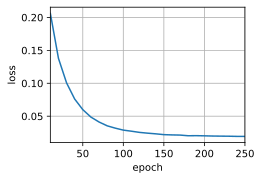

In [5]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens,
                             num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens,
                                  num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

模型训练后，我们用它将几个英语句子翻译成法语并计算它们的 BLEU 分数。


In [6]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est <unk> .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [7]:
attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weight_seq], 0).reshape(
        (1, 1, -1, num_steps))

训练结束后通过可视化注意力权重，我们可以看到，每个查询都会在键值对上分配不同的权重。它显示，在每个解码步骤中，输入序列的不同部分被选择性地聚集在注意力池中。


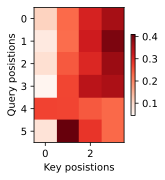

In [8]:
# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key posistions', ylabel='Query posistions')

## 小结

* 在预测标记时，如果不是所有输入标记都是相关的，那么具有 Bahdanau 注意力的循环神经网络编码器-解码器会有选择地统计输入序列的不同部分。这是通过将上下文变量视为加法注意力池的输出来实现的。
* 在循环神经网络编码器-解码器中，Bahdanau 注意力将上一个时间步的解码器隐藏状态视为查询，在所有时间步长编码器隐藏状态同时视为键和值。

## 练习

1. 在实验中用 LSTM 替换 GRU。
1. 修改实验以将加法注意力评分功能替换为缩放的点积。它如何影响训练效率？


[Discussions](https://discuss.d2l.ai/t/1065)
